<h1>MBA Reliability Analysis  </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>
<br>
<h7>4/2/22</h7>

In [5]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [ ]:
%%toggle_code

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

Executed


<h3> SQL Queries

In [9]:
peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    --APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


udpLossSQL = """
SELECT 
count(DISTINCT udploss.unit_id) as totalOutages, 
mt.ISP as ISP, 
mt.Technology as tech, 
mt.Download as DownloadTier, 
avg(udploss.duration/1000) as avgOutageMs, 
APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(50)] as medianOutageMbps,
APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(80)] as twentyPctOutageMbps,
APPROX_QUANTILES(udploss.duration/1000, 100)[OFFSET(95)] as fifthpctOutageMbps,
avg(udploss.packets) as avgPacketLoss, 
APPROX_QUANTILES(udploss.packets, 100)[OFFSET(50)] as medianPacketLoss,
APPROX_QUANTILES(udploss.packets, 100)[OFFSET(95)] as fifthPctPacketLoss,
FROM `broadband-data.mba_data.curr_udpcloss` as udploss 
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON udploss.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM udploss.dtime) >= 19) AND (EXTRACT(HOUR FROM udploss.dtime) <=23) AND
            udploss.ddate < (CAST('2020-10-01' as DATE)) 
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING totalOutages >=5
ORDER BY  mt.Download, mt.ISP, mt.Technology
"""


dnsSQL = """
SELECT mt.Download as DownloadTier, mt.ISP as ISP, mt.Technology as tech, 
avg(dns.rtt/1000) as avgRTTms,
APPROX_QUANTILES(dns.rtt/1000, 100)[OFFSET(50)] as medianRTTms,
APPROX_QUANTILES(dns.rtt/1000, 100)[OFFSET(80)] as twentyPctRTTms,
APPROX_QUANTILES(dns.rtt/1000, 100)[OFFSET(95)] as fivePctRTTms,
COUNT(CASE WHEN dns.successes = 1 THEN 1 END) as successCount,
COUNT(CASE WHEN dns.failures = 1 THEN 1 END) as failureCount,
COUNT(dns.unit_id) as totalTests,
COUNT (DISTINCT dns.unit_id) as totalSubscribers
FROM `broadband-data.mba_data.curr_dns` as dns
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON dns.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM dns.dtime) >= 19) AND (EXTRACT(HOUR FROM dns.dtime) <=23) AND
            dns.ddate < (CAST('2020-10-01' as DATE)) 
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING totalSubscribers >= 10
ORDER BY mt.Download, mt.Technology, mt.ISP
"""





pingSQL = """
SELECT 
mt.Download as DownloadTier, mt.ISP as ISP, mt.Technology as tech,
avg(ping.rtt_avg/1000) as avgPingRTTms, 
APPROX_QUANTILES(ping.rtt_avg/1000, 100)[OFFSET(50)] as medianPingRTTms,
APPROX_QUANTILES(ping.rtt_avg/1000, 100)[OFFSET(80)] as twentyPctPingRTTms,
avg(ping.successes)  as avgPingSuccessCount,
avg(ping.failures) as avgPingFailureCount,
COUNT(ping.unit_id) as totalTests,
COUNT (DISTINCT ping.unit_id) as pingTotalSubscribers, 
avg(ping.rtt_min/1000) as avgPingMinRTTms, 
avg(ping.rtt_max/1000) as avgPingMaxRTTms, 
avg(ping.rtt_std/1000) as avgPingRTTSTDms 
FROM `broadband-data.mba_data.curr_ping` as ping
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON ping.unit_id=mt.Unit_ID
WHERE (EXTRACT(HOUR FROM ping.dtime) >= 19) AND (EXTRACT(HOUR FROM ping.dtime) <=23) AND ping.ddate < (CAST('2020-10-01' as DATE)) 
GROUP BY mt.ISP, mt.Download, mt.Technology
HAVING pingTotalSubscribers >= 10
ORDER BY mt.Download, mt.Technology, mt.ISP
"""




dnsData = client.query(dnsSQL).to_dataframe()
peakDownload = client.query(peak_download_sql).to_dataframe()
udpLoss = client.query(udpLossSQL).to_dataframe()
pingData = client.query(pingSQL).to_dataframe()
print('executed')


executed


In [10]:
peakDownload = peakDownload.rename(columns={"download_service_tier": "DownloadTier",
                                           "low_5_pct_Mbps": "5thPct", "low_20_pct_Mbps": "20thPct",
                                           "_80_80_": "80/80"})

<h4> Merging peak dowload data, contiguous UDP packet loss data, and DNS resolution data into one dataframe

In [11]:
mergedChart = peakDownload.merge(udpLoss, how = 'inner', on=['ISP', 'DownloadTier', 'tech'])

temp = peakDownload['DownloadTier'].astype(int)
ispTech =  temp.astype(str) +' Mbps'+"\n"+ peakDownload['ISP'] +"\n"+ peakDownload['tech']       
mergedChart['ispTech'] = ispTech
mergedChart['5thPctNorm'] = (mergedChart['5thPct']/mergedChart['DownloadTier']) *100

mergedChart = mergedChart.merge(dnsData, how = 'inner', on=['ISP', 'DownloadTier', 'tech'])
mergedChart = mergedChart.merge(pingData, how = 'inner', on=['ISP', 'DownloadTier', 'tech'])


mergedChart


,DownloadTier,ISP,tech,avg_Mbps,median_Mbps,5thPct,top_95_pct_Mbps,20thPct,max_Mbps,min_Mbps,...,avgPingRTTms,medianPingRTTms,twentyPctPingRTTms,avgPingSuccessCount,avgPingFailureCount,totalTests_y,pingTotalSubscribers,avgPingMinRTTms,avgPingMaxRTTms,avgPingRTTSTDms
0,1.5,CenturyLink,DSL,1.209852,1.235936,0.662552,1.493808,1.062544,1.934584,0.022072,...,111.502227,76.502,105.588,4.863811,0.136189,12512,64,94.162253,134.403082,17.873489
1,3.0,CenturyLink,DSL,2.850427,2.827840,1.484872,4.765216,2.205512,5.404400,0.016840,...,86.038002,65.033,90.232,4.871638,0.128362,9816,50,75.932731,98.959910,10.366681
2,3.0,Comcast,Cable,3.508154,3.557160,3.275760,3.576600,3.538552,3.607728,0.262824,...,20.602735,16.846,25.500,4.997189,0.002811,2490,10,18.239635,24.473933,2.670336
3,3.0,Frontier,DSL,2.419134,2.613336,1.191064,3.637872,1.693800,3.998760,0.276048,...,45.975108,34.494,53.373,4.952663,0.047337,4732,24,37.063702,60.630831,10.465581
4,3.0,Verizon DSL,DSL,2.014080,2.306080,0.556408,2.804376,1.204488,2.846840,0.115192,...,68.897630,36.964,57.704,4.944504,0.055496,4703,22,52.715197,93.170576,18.265490
5,3.0,Windstream,DSL,2.593213,2.656904,0.546352,3.443464,2.091560,4.398760,0.020112,...,79.551101,44.538,66.932,4.879637,0.120363,1213,13,59.586145,105.976467,20.782894
6,4.0,Windstream,DSL,4.028276,4.367472,2.272936,4.414384,3.866920,4.609920,0.305016,...,44.592767,40.478,46.497,4.931548,0.068452,1344,18,39.200263,53.013935,6.222036
7,5.0,Cincinnati Bell,DSL,3.696203,4.214408,1.237952,4.327232,3.171976,4.814376,0.249400,...,48.808965,33.504,54.951,4.914533,0.085467,5078,47,43.287607,56.966104,6.171008
8,6.0,Frontier,DSL,5.430807,5.683632,1.655800,7.893608,4.337272,9.551024,0.443104,...,34.328451,21.953,32.945,4.936945,0.063055,7438,35,28.009360,43.864966,7.015548
9,6.0,Windstream,DSL,5.981172,5.981944,4.684768,6.857912,5.792000,6.946528,0.211760,...,56.452777,38.106,47.237,4.949269,0.050731,1163,10,52.454081,62.155886,4.293347


<h2> ICMP Ping Data Analysis (IPv4)

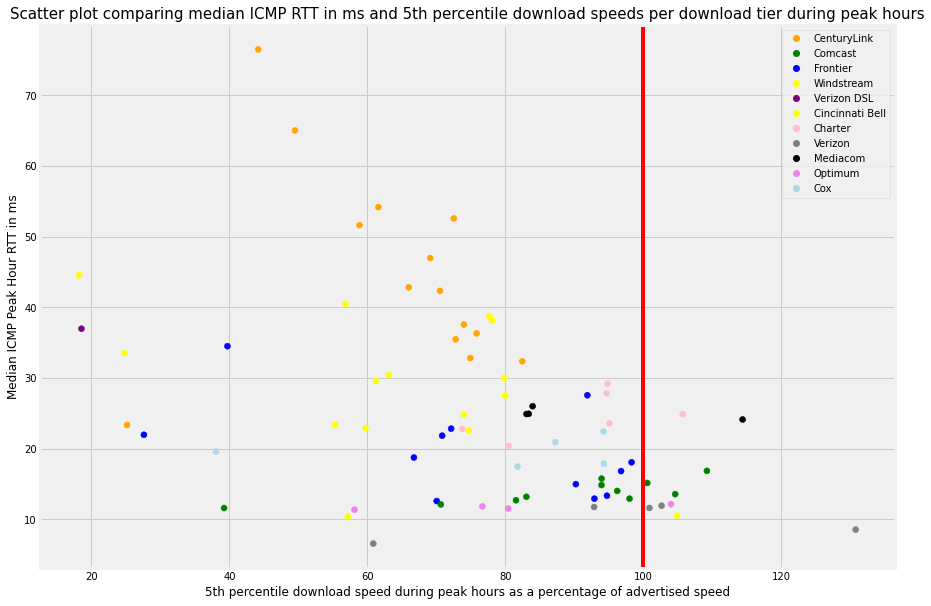

In [22]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['medianPingRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speed")
plt.ylabel("Median ICMP Peak Hour RTT in ms")
plt.title("Scatter plot comparing median ICMP RTT in milliseconds (ms) and 5th percentile download speeds per download tier during peak hours",fontsize=15)


    Download Speed (Mbps) / \n Advertised Tier Speed (%)
plt.show()

In [8]:
kenPing1 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['medianPingRTTms'])
print("KendallTau Median ICMP RTT in ms vs 5pctMbps per download tier (normalized):", kenPing1)
print('\n')
sPing1 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['medianPingRTTms'])
print("Spearman Median ICMP RTT in ms vs 5pctMbps (normalized) per download tier:", sPing1)

KendallTau Median ICMP RTT in ms vs 5pctMbps per download tier (normalized): KendalltauResult(correlation=-0.30143540669856456, pvalue=0.00010475460629774573)


Spearman Median ICMP RTT in ms vs 5pctMbps (normalized) per download tier: SpearmanrResult(correlation=-0.41474315158525676, pvalue=0.0001766787638061754)


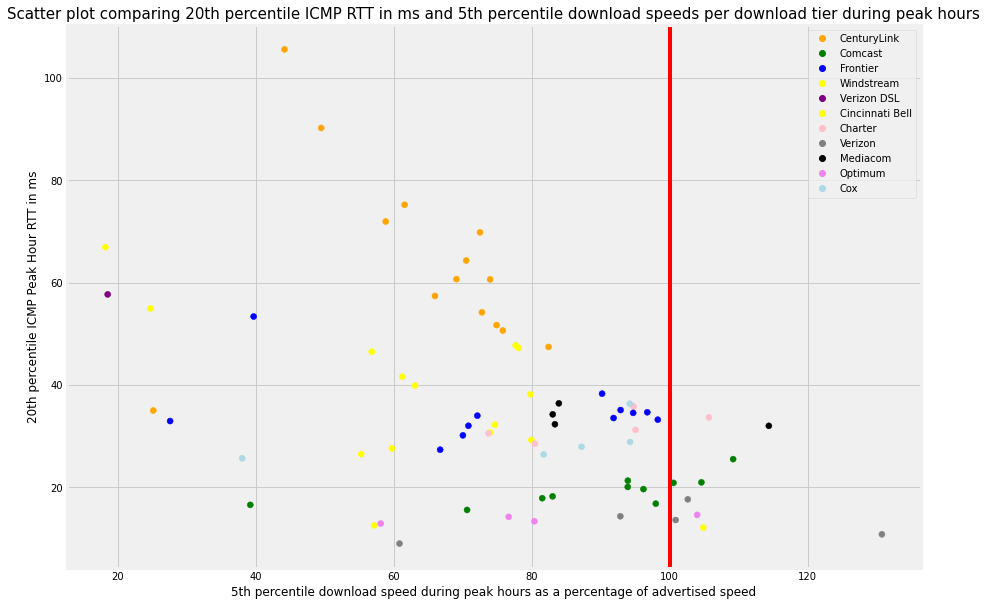

In [9]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['twentyPctPingRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speed")
plt.ylabel("20th percentile ICMP Peak Hour RTT in ms")
plt.title("Scatter plot comparing 20th percentile ICMP RTT in ms and 5th percentile download speeds per download tier during peak hours",fontsize=15)


    
plt.show()

In [10]:
kenPing2 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['twentyPctPingRTTms'])
print("KendallTau 20th Percentile ICMP RTT in ms vs 5pctMbps per download tier (normalized):", kenPing2)
print('\n')
sPing2 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['twentyPctPingRTTms'])
print("Spearman 20th Percentile ICMP RTT in ms vs 5pctMbps (normalized) per download tier:", sPing2)

KendallTau 20th Percentile ICMP RTT in ms vs 5pctMbps per download tier (normalized): KendalltauResult(correlation=-0.28844839371155157, pvalue=0.0002054890434484437)


Spearman 20th Percentile ICMP RTT in ms vs 5pctMbps (normalized) per download tier: SpearmanrResult(correlation=-0.3892686261107313, pvalue=0.00046693503488298813)


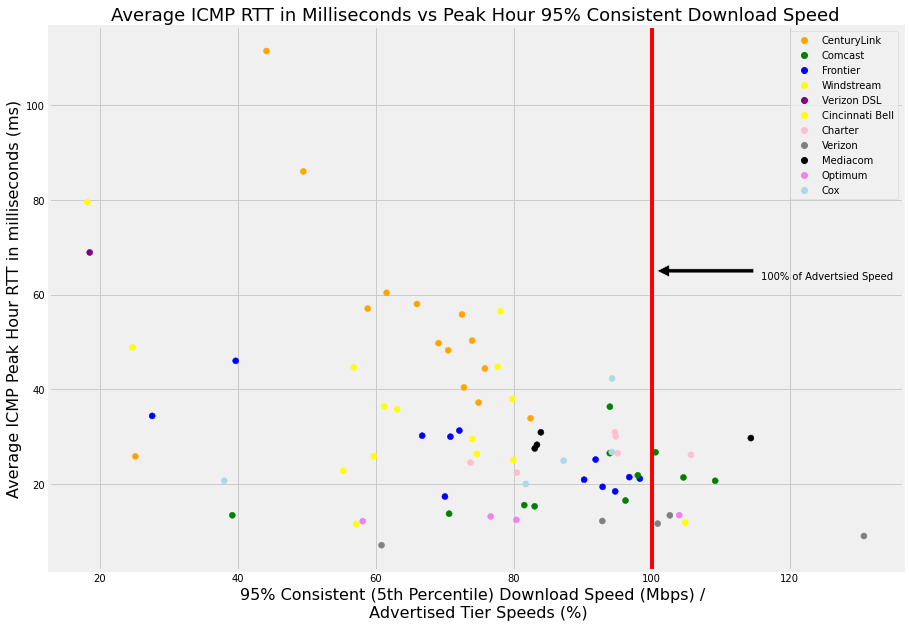

In [31]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['avgPingRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
# ax1.annotate("100% of Advertsied Speed", (105, 60), fontsize=12)

ax1.annotate('100% of Advertsied Speed',
            xy=(100, 65),
            xytext=(135, 65), arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% Consistent (5th Percentile) Download Speed (Mbps) / \n Advertised Tier Speeds (%)", fontsize=16)
plt.ylabel("Average ICMP Peak Hour RTT in milliseconds (ms)", fontsize=16)
plt.title("Average ICMP RTT in Milliseconds vs Peak Hour 95% Consistent Download Speed",fontsize=18)


plt.show()

In [82]:
kenPing3 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['avgPingRTTms'])
print("KendallTau Average ICMP RTT in ms vs 5pctMbps per download tier (normalized):", kenPing3)
print('\n')
sPing3 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['avgPingRTTms'])
print("Spearman Average ICMP RTT in ms vs 5pctMbps (normalized) per download tier:", sPing3)

KendallTau Average ICMP RTT in ms vs 5pctMbps per download tier (normalized): KendalltauResult(correlation=-0.30690362269309635, pvalue=7.82558697746615e-05)


Spearman Average ICMP RTT in ms vs 5pctMbps (normalized) per download tier: SpearmanrResult(correlation=-0.4162153635837846, pvalue=0.0001666275922930219)


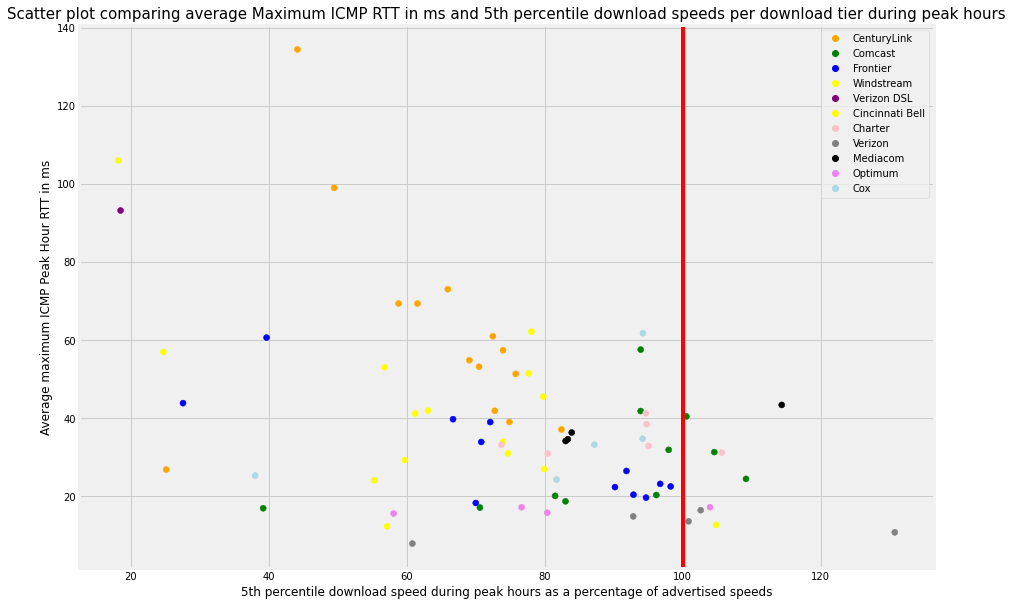

In [12]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['avgPingMaxRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Average maximum ICMP Peak Hour RTT in ms")
plt.title("Scatter plot comparing average Maximum ICMP RTT in ms and 5th percentile download speeds per download tier during peak hours",fontsize=15)


plt.show()

In [13]:
kenPing4 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['avgPingMaxRTTms'])
print("KendallTau Average Maximum ICMP RTT in ms vs 5pctMbps per download tier (normalized):", kenPing4)
print('\n')
sPing4 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['avgPingMaxRTTms'])
print("Spearman Average Maximum ICMP RTT in ms vs 5pctMbps (normalized) per download tier:", sPing4)

KendallTau Average Maximum ICMP RTT in ms vs 5pctMbps per download tier (normalized): KendalltauResult(correlation=-0.2631578947368421, pvalue=0.0007073964164087877)


Spearman Average Maximum ICMP RTT in ms vs 5pctMbps (normalized) per download tier: SpearmanrResult(correlation=-0.3565381986434618, pvalue=0.0014589401838688914)


<h2> DNS Resolution Analysis

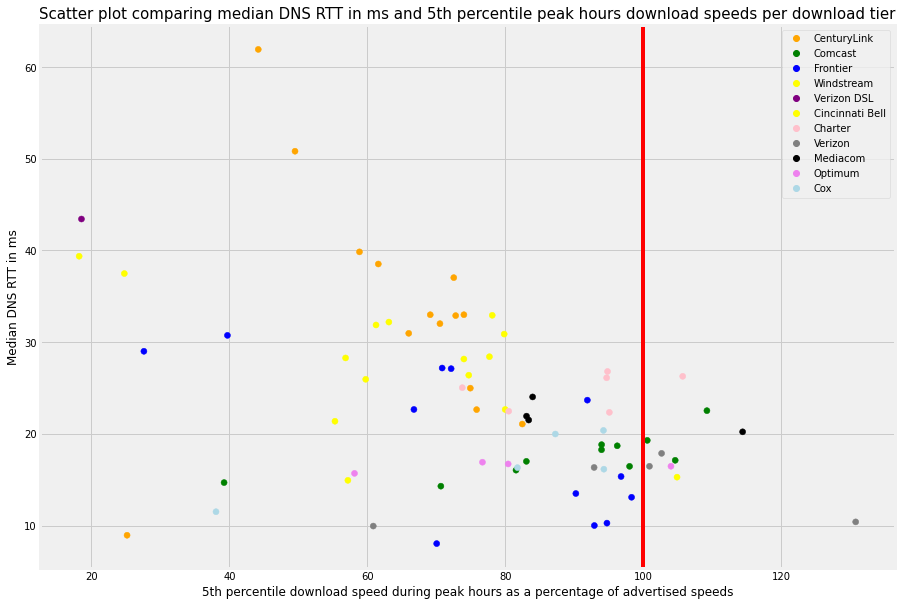

In [14]:
annotations = mergedChart['DownloadTier']


X =  mergedChart['5thPctNorm']
Y = mergedChart['medianRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Median DNS RTT in ms")
plt.title("Scatter plot comparing median DNS RTT in ms and 5th percentile peak hours download speeds per download tier",fontsize=15)

# for i, label in enumerate(annotations):
#     plt.text(X[i], Y[i],label)
    
    
plt.show()

In [86]:
ken1 = stats.kendalltau(X, Y)
print("KendallTau Median DNS RTT in msloss vs 5pctMbps per download tier (normalized):", ken1)
print('\n')
sp1 = stats.spearmanr(X, Y)
print("Spearman Median DNS RTT in ms vs 5pctMbps (normalized) per download tier:", sp1)

KendallTau Median DNS RTT in msloss vs 5pctMbps per download tier (normalized): KendalltauResult(correlation=-0.31960349125138765, pvalue=3.914708298032722e-05)


Spearman Median DNS RTT in ms vs 5pctMbps (normalized) per download tier: SpearmanrResult(correlation=-0.41481160164154796, pvalue=0.00017619932489438325)


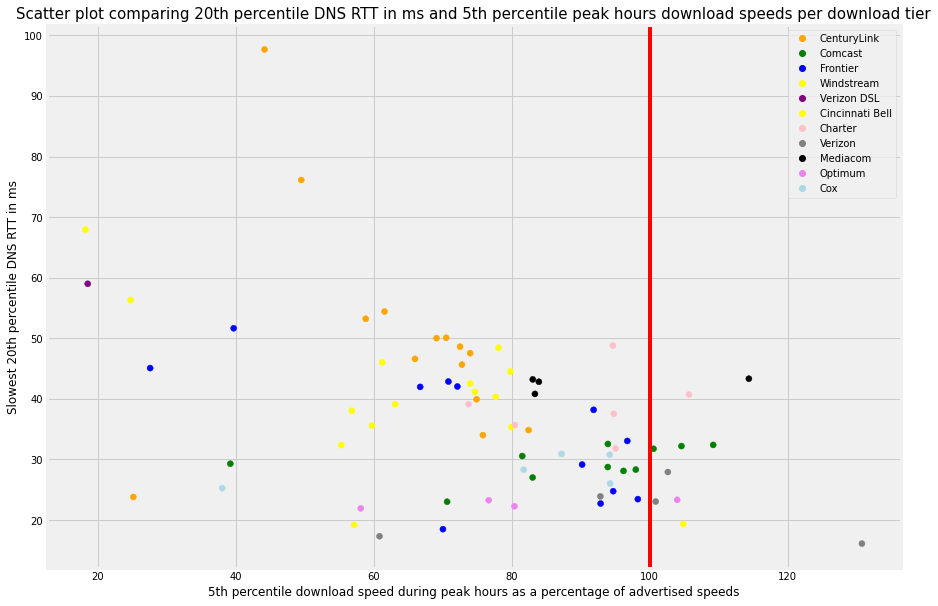

In [15]:
annotations = mergedChart['DownloadTier']

X2 =  mergedChart['5thPctNorm']
Y2 =  mergedChart['twentyPctRTTms']



fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X2, Y2, c=mergedChart['ISP'].map(colors))
plt.grid(True)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Slowest 20th percentile DNS RTT in ms")
plt.title("Scatter plot comparing 20th percentile DNS RTT in ms and 5th percentile peak hours download speeds per download tier",fontsize=15)

# for i, label in enumerate(annotations):
#     plt.text(X[i], Y[i],label)
    
    
plt.show()

In [88]:
ken2 = stats.kendalltau(X2, Y2)
print("KendallTau 20th percentile DNS RTT in msloss vs 5pctMbps per download tier (normalized):\n", ken2)

print('\n')

sp2 = stats.spearmanr(X2, Y2)
print("Spearman 20th percentile DNS RTT in ms vs 5pctMbps (normalized) per download tier:\n", sp2)

KendallTau 20th percentile DNS RTT in msloss vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=-0.3082706766917293, pvalue=7.269974922610949e-05)


Spearman 20th percentile DNS RTT in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=-0.40159840159840154, pvalue=0.00029456614767624)


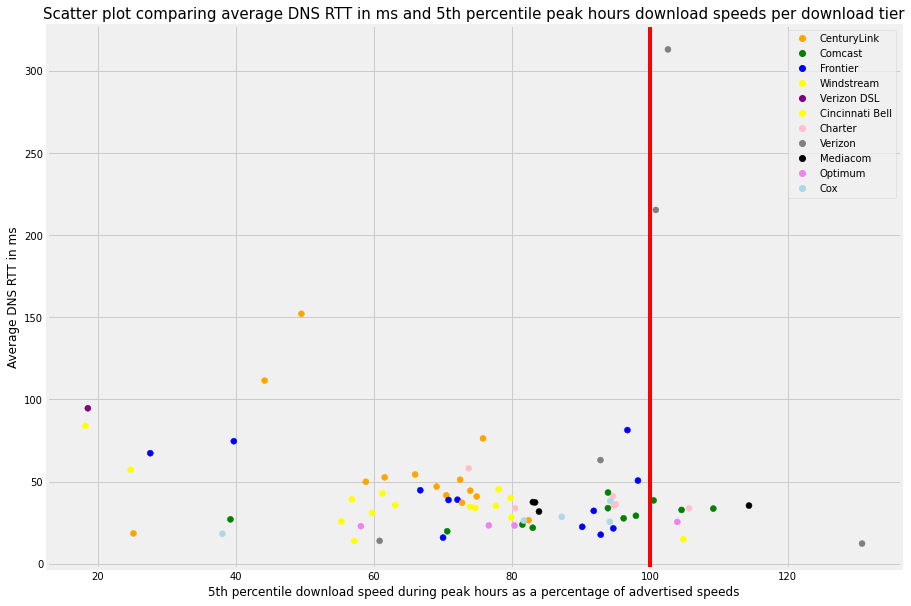

In [16]:
annotations = mergedChart['DownloadTier']


X4 =  mergedChart['5thPctNorm']
Y4 =  mergedChart['avgRTTms']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X4, Y4, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Average DNS RTT in ms")
plt.title("Scatter plot comparing average DNS RTT in ms and 5th percentile peak hours download speeds per download tier",fontsize=15)

# for i, label in enumerate(annotations):
#     plt.text(X[i], Y[i],label)
    
    
plt.show()

In [90]:
ken4 = stats.kendalltau(X4, Y4)
print("KendallTau Average DNS RTT in msloss vs 5pctMbps per download tier (normalized):\n", ken4)

print('\n')

sp4 = stats.spearmanr(X4, Y4)
print("Spearman Average DNS RTT in ms vs 5pctMbps (normalized) per download tier:\n", sp4)

KendallTau Average DNS RTT in msloss vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=-0.14080656185919344, pvalue=0.06997036779882723)


Spearman Average DNS RTT in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=-0.1898890583101109, pvalue=0.09810663876209529)


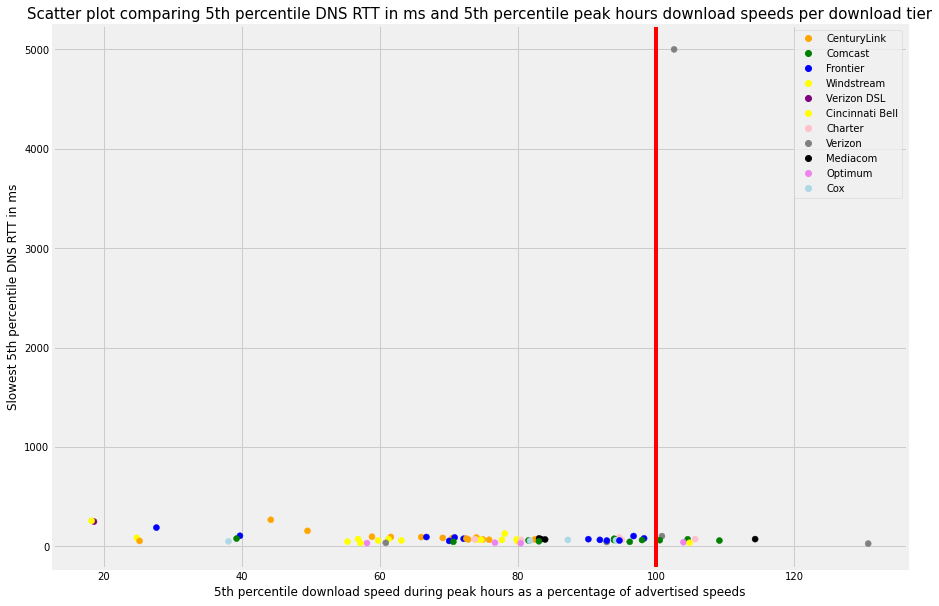

In [17]:
annotations = mergedChart['DownloadTier']
X3 =  mergedChart['5thPctNorm']
Y3 =  mergedChart['fivePctRTTms']
fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)
colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}

ax1.scatter(X3, Y3, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Slowest 5th percentile DNS RTT in ms")
plt.title("Scatter plot comparing 5th percentile DNS RTT in ms and 5th percentile peak hours download speeds per download tier",fontsize=15)

# for i, label in enumerate(annotations):
#     plt.text(X[i], Y[i],label)
    
    
plt.show()

In [92]:
ken3 = stats.kendalltau(X3, Y3)
print("KendallTau 5th percentile DNS RTT in msloss vs 5pctMbps per download tier (normalized):\n", ken3)

print('\n')

sp3 = stats.spearmanr(X3, Y3)
print("Spearman 5th percentile DNS RTT in ms vs 5pctMbps (normalized) per download tier:\n", sp3)

KendallTau 5th percentile DNS RTT in msloss vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=-0.18796992481203006, pvalue=0.015560296624620431)


Spearman 5th percentile DNS RTT in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=-0.23331931226668065, pvalue=0.04113571743177021)


<h3> Contiguous UDP packet loss (disconnections/outage detection) Analysis

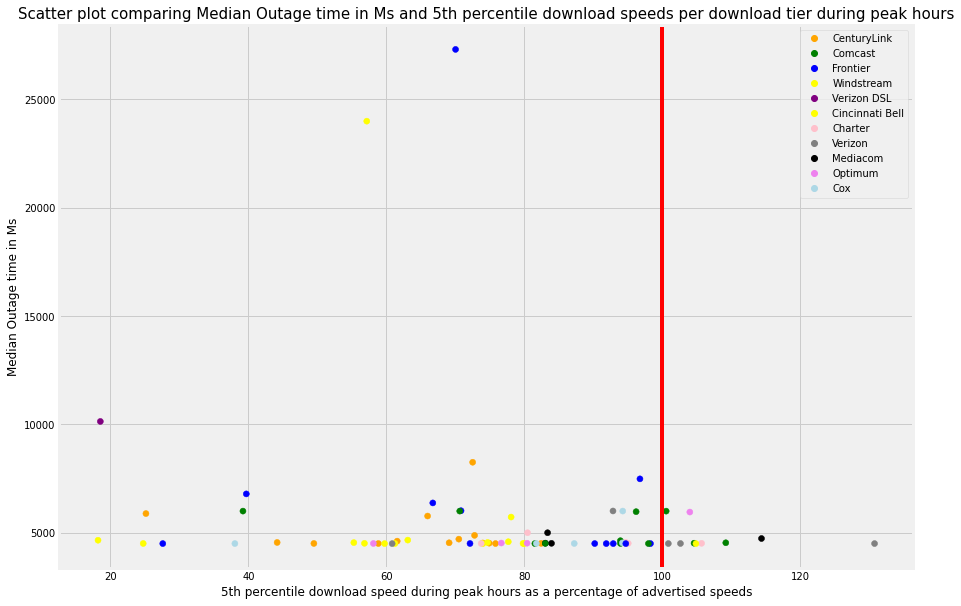

In [18]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['medianOutageMbps']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Median Outage time in Ms")
plt.title("Scatter plot comparing Median Outage time in Ms and 5th percentile download speeds per download tier during peak hours",fontsize=15)


plt.show()

In [95]:
kenUDPLoss1 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['medianOutageMbps'])
print("KendallTau Median Outage time in ms vs 5pctMbps per download tier (normalized):\n", kenUDPLoss1)

print('\n')

spUDPLoss1 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['medianOutageMbps'])
print("Spearman Median Outage time in ms vs 5pctMbps (normalized) per download tier:\n", spUDPLoss1)

KendallTau Median Outage time in ms vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=-0.11004784688995214, pvalue=0.15670090832082686)


Spearman Median Outage time in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=-0.16015563383984435, pvalue=0.1641123913414821)


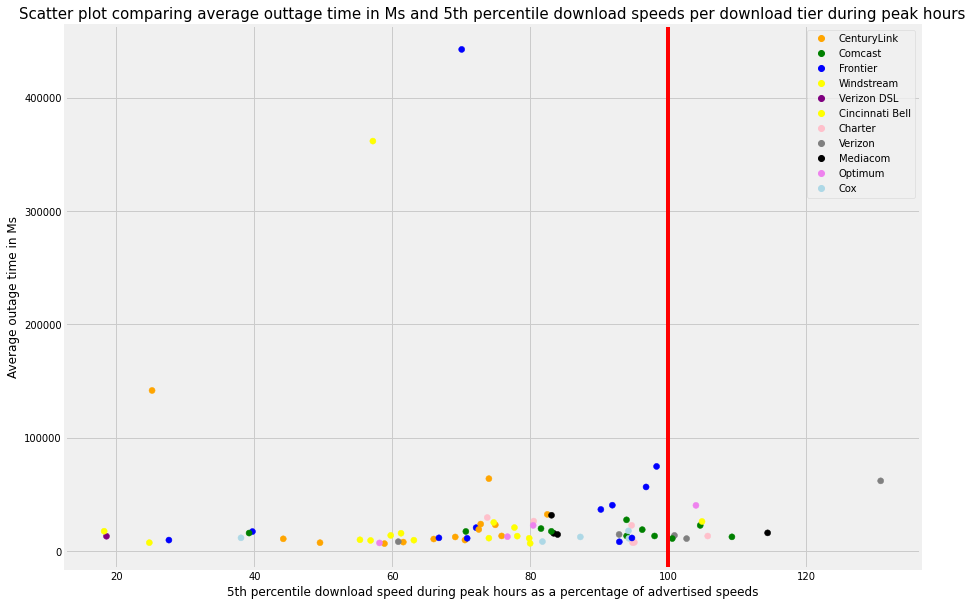

In [19]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['avgOutageMs']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("Average outage time in Ms")
plt.title("Scatter plot comparing average outtage time in Ms and 5th percentile download speeds per download tier during peak hours",fontsize=15)


plt.show()

In [97]:
kenUDPLoss2 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['avgOutageMs'])
print("KendallTau Average Outage time in ms vs 5pctMbps per download tier (normalized):\n", kenUDPLoss2)

print('\n')

spUDPLoss2 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['avgOutageMs'])
print("Spearman Average Outage time in ms vs 5pctMbps (normalized) per download tier:\n", spUDPLoss2)

KendallTau Average Outage time in ms vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=0.17224880382775118, pvalue=0.026640406476243897)


Spearman Average Outage time in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=0.25251064724748934, pvalue=0.02672118837946886)


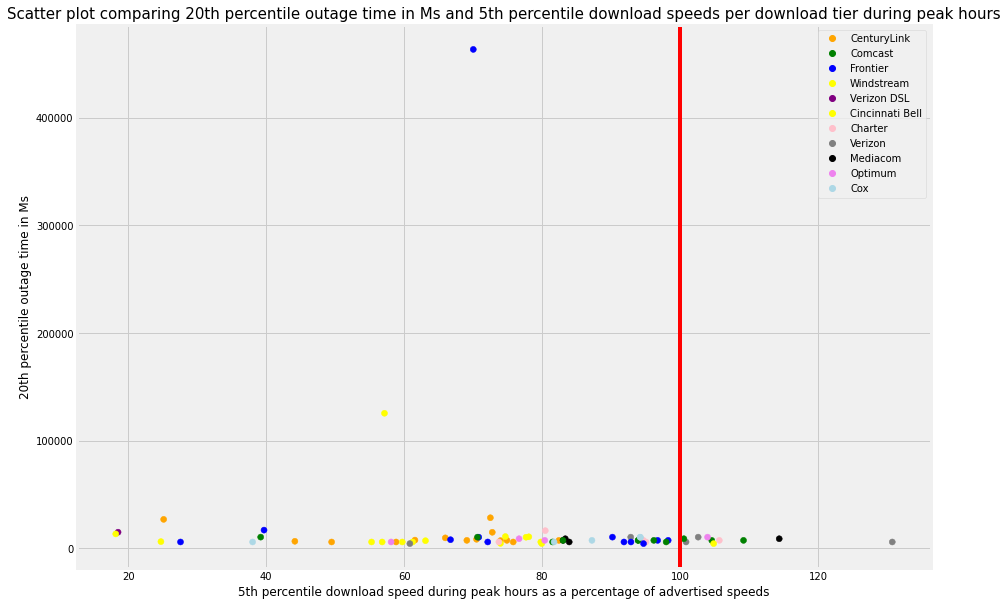

In [20]:
X =  mergedChart['5thPctNorm']
Y = mergedChart['twentyPctOutageMbps']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("20th percentile outage time in Ms")
plt.title("Scatter plot comparing 20th percentile outage time in Ms and 5th percentile download speeds per download tier during peak hours",fontsize=15)


plt.show()

In [99]:
kenUDPLoss4 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['twentyPctOutageMbps'])
print("KendallTau 20th percentile Outage time in ms vs 5pctMbps per download tier (normalized):\n", kenUDPLoss4)

print('\n')

spUDPLoss4 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['twentyPctOutageMbps'])
print("Spearman 20th percentile Outage time in ms vs 5pctMbps (normalized) per download tier:\n", spUDPLoss4)

KendallTau 20th percentile Outage time in ms vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=-0.04442925495557074, pvalue=0.567471096531954)


Spearman 20th percentile Outage time in ms vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=-0.07295336242704663, pvalue=0.5283456322953766)


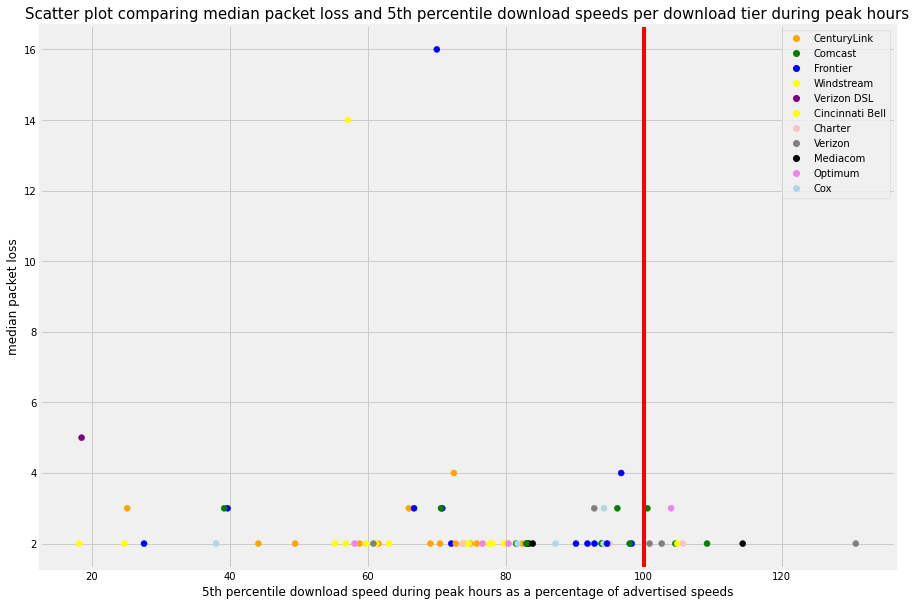

In [21]:
X = mergedChart['5thPctNorm']
Y = mergedChart['medianPacketLoss']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

colors = {'CenturyLink':'orange', 'Comcast':'green', 'Frontier':'blue', 'Windstream':'yellow',
         'Verizon DSL': 'purple', 'Cincinnati Bell': 'yellow', 'Charter': 'pink', 'Verizon': 'gray', 
         'Mediacom': 'black', 'Optimum': 'violet', 'Cox': 'lightblue'}


ax1.scatter(X, Y, c=mergedChart['ISP'].map(colors))
plt.grid(True)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1)
plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("5th percentile download speed during peak hours as a percentage of advertised speeds")
plt.ylabel("median packet loss")
plt.title("Scatter plot comparing median packet loss and 5th percentile download speeds per download tier during peak hours",fontsize=15)


plt.show()

In [101]:
kenUDPLoss3 = stats.kendalltau(mergedChart['5thPctNorm'], mergedChart['avgOutageMs'])
print("KendallTau Median packet loss vs 5pctMbps per download tier (normalized):\n", kenUDPLoss3)

print('\n')

spUDPLoss3 = stats.spearmanr(mergedChart['5thPctNorm'], mergedChart['avgOutageMs'])
print("Spearman Median packet loss vs 5pctMbps (normalized) per download tier:\n", spUDPLoss3)

KendallTau Median packet loss vs 5pctMbps per download tier (normalized):
 KendalltauResult(correlation=0.17224880382775118, pvalue=0.026640406476243897)


Spearman Median packet loss vs 5pctMbps (normalized) per download tier:
 SpearmanrResult(correlation=0.25251064724748934, pvalue=0.02672118837946886)
